In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import pandas as pd
import shap


In [31]:
class Autoencoder(nn.Module):
  def __init__(self, input_size, hidden_size, latent_size):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      nn.ReLU(), # should decide on the relu variant, but it's just basic relu rn as a placeholder
      nn.Linear(hidden_size, latent_size),
      nn.ReLU()
    )
    self.decoder = nn.Sequential(
      nn.Linear(latent_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, input_size),
      nn.ReLU()
    )

  def forward(self, x):
    x = self.encoder(x)
    
    x = self.decoder(x)
    return x

In [32]:
data_np = np.loadtxt('kmer_counts_feature_mat_row_normalized.csv', delimiter=',')
data = data_np

In [33]:
max_value = np.max(data)
max_value

28364738.0

In [34]:
max_values = data.max(axis=1)
data = data / max_values[:, None]

data

array([[0.66930811, 0.37505256, 0.55402299, ..., 0.50120646, 0.16440073,
        0.33303595],
       [0.45977047, 0.37726142, 0.52801364, ..., 0.71005052, 0.25758662,
        0.2794055 ],
       [0.63408919, 0.40316126, 0.55893977, ..., 0.52683908, 0.17441955,
        0.33215718],
       ...,
       [0.68240982, 0.37887219, 0.5583169 , ..., 0.6518597 , 0.16040667,
        0.32756848],
       [0.42674899, 0.34147396, 0.48468017, ..., 0.49705729, 0.19319455,
        0.20310101],
       [0.84487912, 0.35208369, 0.53898338, ..., 0.58837247, 0.1875713 ,
        0.26295755]])

In [35]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset, random_split

# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # to run on GPU on colab, go to runtime > change runtime type > T4 GPU

# define dimensions
input_size = data.shape[1]  # 10000
hidden_size = 400
latent_size = 100

# make model, instance of autoencoder
model = Autoencoder(input_size, hidden_size, latent_size).to(device)

# binary cross entropy (since output is in [0, 1])
loss_fn = nn.MSELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# random data - replace with actual matrix
# data = np.random.rand(1700, 10000)

# convert to tensor so it can be inputted
data = torch.tensor(data, dtype=torch.float).to(device)

# create dataset
dataset = TensorDataset(data, data)  # the first arg is the input, the second is the target. for autoencoder they're the same

# split data into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# make dataloaders for training and validation
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []

# train model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # set model to training mode
    epoch_loss = 0.0
    for batch_data, _ in train_dataloader:
        batch_data = batch_data.to(device)

        # forward pass
        outputs = model(batch_data)
        loss = loss_fn(outputs, batch_data)
        epoch_loss += loss.item()

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(epoch_loss / len(train_dataloader))

    # validation loss
    model.eval()  # set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # no gradient calculation for validation
        for batch_data, _ in val_dataloader:
            batch_data = batch_data.to(device)

            # forward pass
            outputs = model(batch_data)
            loss = loss_fn(outputs, batch_data)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_dataloader))

    # print epoch loss and validation loss
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - '
              f'Training Loss: {epoch_loss / len(train_dataloader):.4f} - '
              f'Validation Loss: {val_loss / len(val_dataloader):.4f}')


cuda
Epoch [10/100] - Training Loss: 0.0029 - Validation Loss: 0.0029
Epoch [20/100] - Training Loss: 0.0022 - Validation Loss: 0.0022
Epoch [30/100] - Training Loss: 0.0019 - Validation Loss: 0.0019
Epoch [40/100] - Training Loss: 0.0017 - Validation Loss: 0.0018
Epoch [50/100] - Training Loss: 0.0016 - Validation Loss: 0.0016
Epoch [60/100] - Training Loss: 0.0015 - Validation Loss: 0.0015
Epoch [70/100] - Training Loss: 0.0014 - Validation Loss: 0.0015
Epoch [80/100] - Training Loss: 0.0014 - Validation Loss: 0.0014
Epoch [90/100] - Training Loss: 0.0014 - Validation Loss: 0.0014
Epoch [100/100] - Training Loss: 0.0013 - Validation Loss: 0.0014


In [36]:
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=32896, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=32896, bias=True)
    (3): ReLU()
  )
)

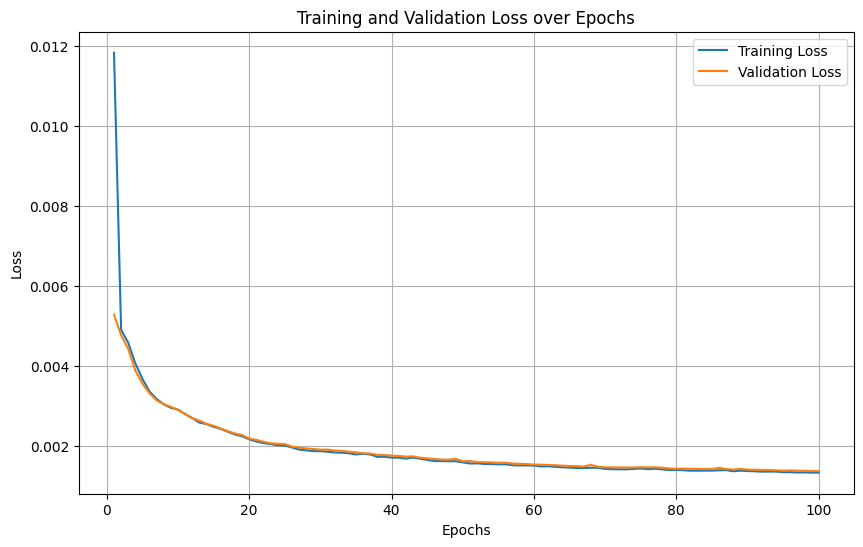

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# generate the background noise for each sample.
means = np.mean(data_np, axis=1)
stds = np.std(data_np, axis=1)
overall_mean = np.mean(means)
overall_std = np.mean(stds)

num_feats = data_np.shape[1]


def make_random_seq():
    # make a sequence of random numbers, then normalize it
    noise = np.random.normal(loc=overall_mean, scale=overall_std, size=num_feats)
    noise_normalized = (noise - noise.min()) / (noise.max() - noise.min())

    return noise_normalized

background_noise = []
for i in range(10):
    background_noise.append(make_random_seq())
    
noise_stack = np.stack(background_noise)
noise_tensor = torch.tensor(noise_stack, dtype=torch.float32)
noise_tensor.shape

torch.Size([10, 32896])

In [47]:
# get random 300 samples (for shap)
rand_inds_300 = torch.randint(0, data.size(0), (300,))
len(rand_inds_300)
data_300 = data[rand_inds_300]

In [50]:
print("start of shap")
# random_indices = np.random.choice(data.shape[0], size=10, replace=False) # make size 50 or smth reasonable
# subset_data = data[random_indices]
# print(subset_data.shape)
print(noise_tensor.shape)

explainer = shap.DeepExplainer(model, noise_tensor.to(device))

print("made the explainer")

shap_values_list = []

count = 0
# iterate through the 300 randomly selected samples 
for i in range(data_300.shape[0]):
    sample = data_300[i:i+1]
    # in this sample, find the importance of each feature in predicting every feature
    shap_values = explainer.shap_values(sample.to(device))
    # aggregate the results - get the importance of each feature in this sample
    vals = np.abs(shap_values[0]).mean(0)
    shap_values_list.append(vals)
    count += 1
    print(count)

print("shap values computed")

start of shap
torch.Size([10, 32896])
made the explainer
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263

In [51]:
shap_values_list

[array([1.60249140e-04, 9.18252269e-05, 1.06181458e-04, ...,
        1.29249915e-04, 4.79818224e-05, 6.86401751e-05]),
 array([1.78745726e-04, 9.47668307e-05, 1.12562291e-04, ...,
        1.31693678e-04, 5.28475606e-05, 6.66393028e-05]),
 array([1.60205530e-04, 8.57393198e-05, 1.00536632e-04, ...,
        1.19362669e-04, 4.69228386e-05, 6.12867494e-05]),
 array([1.51079193e-04, 8.41819618e-05, 9.86245412e-05, ...,
        1.17232530e-04, 4.61755407e-05, 6.01291322e-05]),
 array([1.70025214e-04, 9.05416274e-05, 1.04055653e-04, ...,
        1.35078319e-04, 4.92546661e-05, 7.09511514e-05]),
 array([1.75758399e-04, 1.00897347e-04, 1.17779061e-04, ...,
        1.44440751e-04, 5.35371714e-05, 7.62716358e-05]),
 array([1.62460144e-04, 9.38428103e-05, 1.09303589e-04, ...,
        1.34493690e-04, 4.87595515e-05, 7.13041772e-05]),
 array([1.68064736e-04, 9.69964951e-05, 1.13031811e-04, ...,
        1.40246098e-04, 5.03441332e-05, 7.39768111e-05]),
 array([1.61120294e-04, 9.02928616e-05, 1.059648

In [52]:
# shap_values_list[0][0]
# shap_values_list[0].shape
# type(shap_values_list[0])

# get the over all feature importance of each feature
shap_values_mat = np.vstack(shap_values_list)
feature_averages_over_all_samples = np.mean(shap_values_mat, axis=0)

print(feature_averages_over_all_samples)
shap_values_mat


[1.67447199e-04 9.27327223e-05 1.07208824e-04 ... 1.31533694e-04
 4.94829009e-05 6.92683046e-05]


array([[1.60249140e-04, 9.18252269e-05, 1.06181458e-04, ...,
        1.29249915e-04, 4.79818224e-05, 6.86401751e-05],
       [1.78745726e-04, 9.47668307e-05, 1.12562291e-04, ...,
        1.31693678e-04, 5.28475606e-05, 6.66393028e-05],
       [1.60205530e-04, 8.57393198e-05, 1.00536632e-04, ...,
        1.19362669e-04, 4.69228386e-05, 6.12867494e-05],
       ...,
       [1.76255661e-04, 9.54282993e-05, 1.08891442e-04, ...,
        1.29644156e-04, 4.96983869e-05, 7.05684435e-05],
       [1.55414414e-04, 8.36953665e-05, 9.69945309e-05, ...,
        1.19584575e-04, 4.57017517e-05, 6.32413924e-05],
       [1.68627913e-04, 9.70510917e-05, 1.11298072e-04, ...,
        1.39896378e-04, 4.95186080e-05, 7.58454299e-05]])

In [53]:
# vals = np.abs(shap_values_list[0][0]).mean(0)
# len(vals)
with open('feature_shap_values_trial.txt', 'w') as file: # the shap value for each feature based on the current input order
    for shap_val in feature_averages_over_all_samples:
        file.write(f"{shap_val}\n")